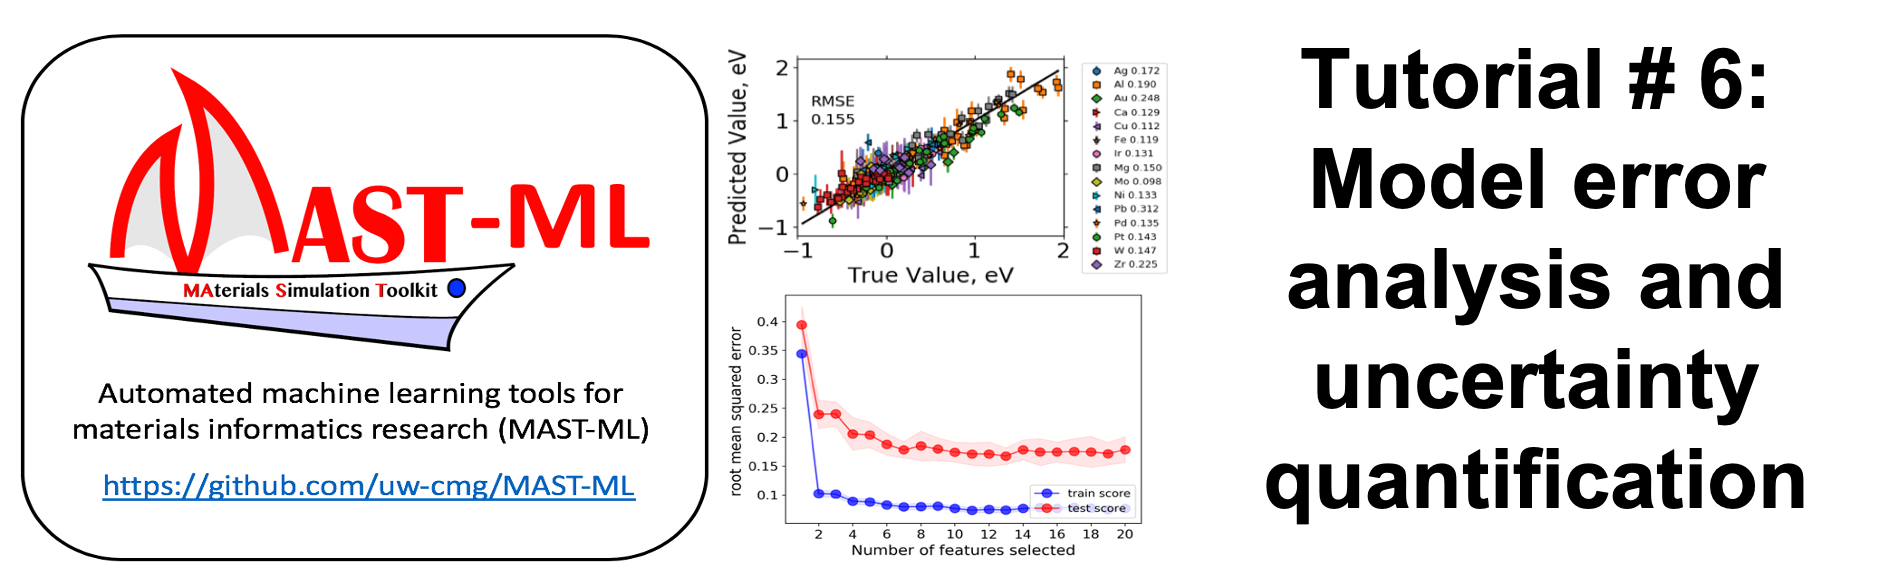

# Welcome to the seventh MAST-ML tutorial notebook, parallel jobs with MAST-ML! 

## In this notebook, we will learn about how MAST-ML can be used to:

1. [Set up MAST-ML on Colab and begin session](#task1)
2. [Run MAST-ML in serial mode for uncertainty quantification](#task2)
3. [Run MAST-ML in parallel mode for uncertainty quantification](#task3)


## Task 1: Set up MAST-ML on Colab and begin session <a name="task1"></a>

If you are working on Google Colab and need to install MAST-ML, 
begin by pip installing MAST-ML to the Colab session
and install the needed dependencies:

In [1]:
!pip install mastml
!pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git

     |████████████████████████████████| 1.1 MB 6.7 MB/s 
     |████████████████████████████████| 1.7 MB 49.4 MB/s 
     |████████████████████████████████| 22.3 MB 1.3 MB/s 
     |████████████████████████████████| 75 kB 5.9 MB/s 
     |████████████████████████████████| 101 kB 14.3 MB/s 
     |████████████████████████████████| 1.4 MB 68.9 MB/s 
     |████████████████████████████████| 85 kB 5.0 MB/s 
     |████████████████████████████████| 3.0 MB 41.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 54 kB 4.5 MB/s 
  Using cached numpy-1.21.2-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
     |████████████████████████████████| 98 kB 8.3 MB/s 
     |████████████████████████████████| 108 kB 72.8 MB/s 
     |████████████████████████████████| 65 kB 5.4 MB/s 
     |████████████████████████████████| 21.8 MB 1.

  Cloning git://github.com/scikit-learn-contrib/forest-confidence-interval.git to /tmp/pip-req-build-5b5xpogb
  Running command git clone -q git://github.com/scikit-learn-contrib/forest-confidence-interval.git /tmp/pip-req-build-5b5xpogb
  Created wheel for forestci: filename=forestci-0.6.dev0-py3-none-any.whl size=11690 sha256=ccdb59db000ba6496ac98fd32ec2d923b57e7b75b82ca17baef39a42c6359c38
  Stored in directory: /tmp/pip-ephem-wheel-cache-skqe3vg0/wheels/77/9e/f3/5fe8b0d60c47dd8559da6824c1d9dc0ab7304a307b235315b2
Successfully built forestci


Sync your Google drive to Colab so that we can save MAST-ML results to our Google
Drive. If we save to the Colab session, the data will be deleted when the session 
ends.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we import the MAST-ML modules used in this tutorial

In [2]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.preprocessing import SklearnPreprocessor
from mastml.models import SklearnModel
from mastml.data_splitters import SklearnDataSplitter
import mastml
import time
import os

data_path = os.path.join(mastml.__path__._path[0], 'data')

Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git


2021-08-20 12:31:24.843975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-20 12:31:24.844100: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Failed to import duecredit due to No module named 'duecredit'


Here, we set the name of the savepath to save MAST-ML results to, and initialize
our MAST-ML run

When the above command is run, a new folder with the name designated SAVEPATH is created.
This is where all of the output for the current MAST-ML run will be saved to.
Note that you can perform multiple runs with the same folder name, and the current datetime
will be appended to the name so that no data is lost or overwritten.

In [3]:
SAVEPATH = 'drive/MyDrive/MASTML_tutorial_7_Parallelization'

mastml = Mastml(savepath=SAVEPATH)
savepath = mastml.get_savepath

## Task 2: Do an unsertainty quantification run in serial <a name="task2"></a>

In this tutorial, we will again use the diffusion dataset that we examined in the previous tutorial, but we will now analyze the speedup of runing in parallel versus serial. Here, we use the LocalDatasets module to load in the diffusion dataset. 

In [4]:
target = 'E_regression'

extra_columns = ['Material compositions 1', 'Material compositions 2']

d = LocalDatasets(file_path=data_path+'/diffusion_data_selectfeatures.xlsx', 
                  target=target, 
                  extra_columns=extra_columns, 
                  group_column='Material compositions 1',
                  testdata_columns=None,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Let's assign each data object to its respective name
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']
X_testdata = data_dict['X_testdata']

When running MAST-ML in serial, only one core does the computation. We can extend the analysis of folds simultaneously to the number of cores we have available in a computer. Let us check out how many cores we have on this machine with the following:

In [5]:
print('We have {} cores to run on.'.format(os.cpu_count()))

We have 16 cores to run on.


For a baseline, let us run MAST-ML in serial mode.

In [10]:
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

model_rf = SklearnModel(model='RandomForestRegressor', n_estimators=150)

metrics = ['r2_score', 'mean_absolute_error', 'root_mean_squared_error', 'rmse_over_stdev']

splitter = SklearnDataSplitter(splitter='RepeatedKFold', n_repeats=1, n_splits=10)

start_time = time.time()  # The start time
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_rf],
                  mastml=mastml,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  error_method='stdev_weak_learners', 
                  verbosity=3)

print('The run time was: {}'.format(time.time()-start_time))

The run time was: 983.3858361244202


## Task 3: Assess the speedup from parallelization <a name="task2"></a>

Since we have n number of cores, we should expect a speedup of n times. However, there are performance losses due to communication between cores, lack of code that can be parallelized, etc. Nevertheless, we can observe a speedup by running in parallel. For a very large number of splits (including repetitions), we can distribute a calculation over many computers to save us time. Conversely, parallelization will introduce small inefficiencies when analyzing a small number of splits. Running in serial for jobs with a small number of folds may be more efficient. Make sure to tune to your specific needs and if you run in parallel, try to make the number of splits a multiple of the requested cores.

In [9]:
splitter = SklearnDataSplitter(
                              splitter='RepeatedKFold',
                               n_repeats=1,
                               parallel_run=True,  # Argument for parallel run
                               n_splits=10)

start_time = time.time()  # The start time
splitter.evaluate(X=X,
                  y=y, 
                  models=[model_rf],
                  mastml=mastml,
                  preprocessor=preprocessor,
                  metrics=metrics,
                  plots=['Error'],
                  savepath=savepath,
                  X_extra=X_extra,
                  nested_CV=True,
                  error_method='stdev_weak_learners',
                  verbosity=3)

print('The run time was: {}'.format(time.time()-start_time))

The run time was: 301.53330969810486
